In [1]:
import numpy as np # use for matrix operation
from PIL import Image
import matplotlib.pyplot as plt # use to plot
from google.colab import files #use to add photo
import io

upload an image file


Saving receipt.jpg to receipt.jpg


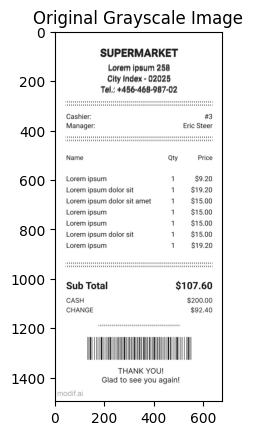

In [2]:
# Upload an image file
print("upload an image file")
uploaded = files.upload()

filename = next(iter(uploaded))
img_bytes = uploaded[filename]

# Open the image from bytes, convert to L
pil_image = Image.open(io.BytesIO(img_bytes)).convert('L')

# Convert the PIL image object to a NumPy array
original_image = np.array(pil_image)

# Display the original image
plt.title("Original Grayscale Image")
plt.imshow(original_image, cmap='gray')
plt.show()

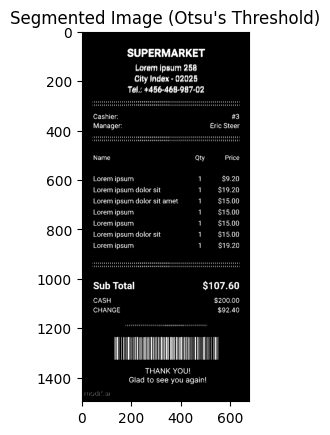

In [3]:
def otsu_threshold(image):

    # Calculate histogram
    hist = np.histogram(image.ravel(), bins=256, range=[0, 256])[0]
    total_pixels = image.size

    # Initialize variables to find the best threshold
    max_var = 0
    best_threshold = 0

    # Loop through all 256 possible thresholds (t)
    for t in range(256):

        # Calculate w_b and w_f (weights for background and foreground)
        w_b = np.sum(hist[:t])
        if w_b == 0:
            continue

        w_f = np.sum(hist[t:])
        if w_f == 0:
            continue

        # Calculate m_b and m_f (means for background and foreground)
        sum_b = 0
        for i in range(t):
            sum_b += i * hist[i]
        m_b = sum_b / w_b

        # mean of foreground
        sum_f = 0
        for i in range(t, 256):
            sum_f += i * hist[i]
        m_f = sum_f / w_f

        # Calculate the "between-class variance"
        var = (w_b * w_f / (total_pixels * total_pixels)) * ((m_b - m_f)**2)

        if var > max_var:
            max_var = var
            best_threshold = t

    # Apply the best threshold to the image
    binary_image = np.zeros_like(image, dtype=np.uint8)
    binary_image[image < best_threshold] = 255

    return binary_image, best_threshold

# Apply the segmentation
segmented_image, optimal_threshold = otsu_threshold(original_image)

# Display the segmented result
plt.title("Segmented Image (Otsu's Threshold)")
plt.imshow(segmented_image, cmap='gray')
plt.show()

This cell defines and runs the otsu_threshold function, which manually implements Otsu's method by calculating the histogram and looping through all levels to find the best_threshold that maximizes between-class variance, finally applying it to display the segmented image.

In [4]:
# Define a 3x3 structuring element (SE) or matrix
SE = np.array(
    [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1] ],
    dtype=np.uint8)


def manual_erode_from_ref(image, se):

    # Performs erosion
    rows, cols = image.shape
    se_rows, se_cols = se.shape
    constant = se_rows // 2
    output_img = np.zeros_like(image, dtype=np.uint8)

    for i in range(constant, rows - constant):
        for j in range(constant, cols - constant):
            temp = image[i-constant : i+constant+1, j-constant : j+constant+1] # Extract the neighborhood
            product = temp * se
            output_img[i, j] = np.min(product)
    return output_img

def manual_dilate_from_ref(image, se):
    #Performs dilation.
    rows, cols = image.shape
    se_rows, se_cols = se.shape

    constant = se_rows // 2
    output_img = np.zeros_like(image, dtype=np.uint8)

    for i in range(constant, rows - constant):
        for j in range(constant, cols - constant):
            temp = image[i-constant : i+constant+1, j-constant : j+constant+1]
            product = temp * se
            output_img[i, j] = np.max(product)

    return output_img

def manual_opening(image, se):
    #Performs opening (erode then dilate)
    eroded = manual_erode_from_ref(image, se)
    opened = manual_dilate_from_ref(eroded, se)
    return opened

def manual_closing(image, se):
    # Performs closing (dilate then erode)
    dilated = manual_dilate_from_ref(image, se)
    closed = manual_erode_from_ref(dilated, se)
    return closed

This cell defines the morphological processing that include the 3x3 SE (Structuring Element), the manual_erode_from_ref (finds minimum), manual_dilate_from_ref (finds maximum), manual_opening (erode then dilate), and manual_closing (dilate then erode) functions.

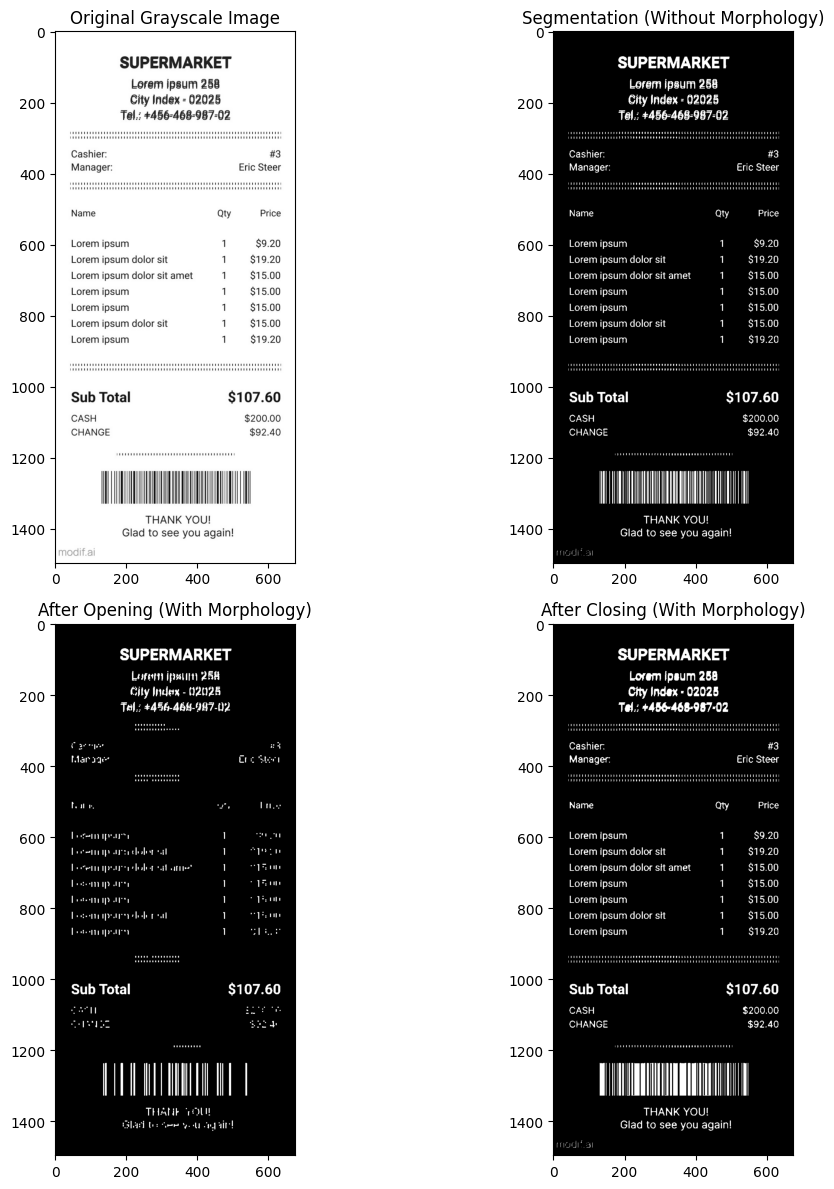

In [5]:
# Apply Opening
opened_image = manual_opening(segmented_image, SE)

# Apply Closing
closed_image = manual_closing(segmented_image, SE)

# comparasion
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(original_image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmentation (Without Morphology)")
plt.imshow(segmented_image, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("After Opening (With Morphology)")
plt.imshow(opened_image, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("After Closing (With Morphology)")
plt.imshow(closed_image, cmap='gray')

plt.tight_layout()
plt.show()

This final cell applies the manual_opening and manual_closing functions to the segmented image and then creates a 2x2 plot to visually compare.